In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import brom_functions as bf
import plot_functions as pf
import linear_fit_functions as lff

#### Open an initial dataset (observed values)

In [2]:
ds = xr.open_dataset('wadden_sea_out.nc')
df = ds.to_dataframe()
levelcntr = df.groupby('levelcntr').get_group(0.625)
levelface = levelcntr.groupby('levelface').get_group(0)
levelface.describe()

,par,hice,snowthick,icesurft,temperature,salinity,sigma,turbulence,nitrate,silicate,phosphate,oxygen,om_flux,chl_a
count,1095.000000,1095.0,1095.0,1095.0,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,56.332397,0.0,0.0,0.0,9.762181,30.002657,25.350036,0.000060,11.562565,8.849457,0.559331,412.414331,0.001395,4.809650
std,23.048964,0.0,0.0,0.0,6.321535,1.060397,1.479595,0.000050,9.615395,7.326062,0.401365,79.802672,0.000877,3.700856
min,21.644333,0.0,0.0,0.0,1.243333,28.625527,22.625049,0.000013,0.115774,0.325987,0.076893,248.039256,0.000155,0.000000
25%,33.247036,0.0,0.0,0.0,4.027208,29.050626,24.194945,0.000034,0.599444,1.870370,0.140375,362.262903,0.000520,2.521583
50%,58.778526,0.0,0.0,0.0,8.949562,29.681462,25.260637,0.000056,11.561208,6.149211,0.501802,392.995298,0.001395,4.386667
75%,79.421547,0.0,0.0,0.0,15.415418,30.894287,26.684076,0.000074,18.925000,16.725000,0.858421,459.170881,0.002270,5.698333
max,86.162720,0.0,0.0,0.0,20.298375,31.924390,28.350891,0.000810,28.034101,23.774999,1.240000,576.916275,0.002635,18.415614


In [3]:
par = levelface['par'].values[0:365].astype(np.float64)
temperature = levelface['temperature'].values[0:365].astype(np.float64)
no3_data = levelface['nitrate'].values[0:365].astype(np.float64)
po4_data = levelface['phosphate'].values[0:365].astype(np.float64)
si_data = levelface['silicate'].values[0:365].astype(np.float64)
o2_data = levelface['oxygen'].values[0:365].astype(np.float64)
chl_a_data = levelface['chl_a'].values[0:365].astype(np.float64)
# daily irradiance
irradiance = par*86400/1000000 # convertion microM per second to M per day

#### Open a data from WOD to take the raw Chlorophyll a data

In [4]:
ds = xr.open_dataset('wadden_sea.nc')
df = ds.to_dataframe()
df = df[(df.date_time > '2000-01-01 00:00:00.0') & (df.var1 < 11)]
df = df[['longitude', 'latitude', 'date_time'
        ,'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'
        ,'var8', 'var9', 'var10', 'var11', 'var12', 'var13', 'var14']]
df.columns = ['longitude', 'latitude', 'date_time'
             ,'Depth', 'Temperature', 'Salinity', 'Oxygen', 'Phosphate', 'Silicate', 'Nitrate'
             ,'Nitrite', 'pH', 'Chlorophyll a', 'Plankton biomass', 'Alkalinity', 'NO2+NO3', 'pCO2']
df['Oxygen'] = df['Oxygen']*44.661 # 1 ml/l = 10^3/22.391 = 44.661 μmol/l
df['Day of year'] = df.date_time.dt.dayofyear.values
dfyear = df[(df.date_time > '2010-01-01 00:00:00.0') & (df.date_time < '2011-01-01 00:00:00.0')]
dfyear = dfyear.groupby(['Day of year']).mean()
dfyear = dfyear.reindex(index=range(1,366))
chl_rawdata = dfyear['Chlorophyll a']

#### There are some initial data

In [5]:
#some common variables
depth = 0.625; k=0; latitude=54.88; days = np.arange(0,364,1)
#nutrients
nh4 = np.zeros(365); nh4[0] = 2 
no2 = np.zeros(365); no2[0] = 1.5
no3 = np.zeros(365); no3[0] = no3_data[0] 
si = np.zeros(365); si[0] = si_data[0] 
po4 = np.zeros(365); po4[0] = po4_data[0] 
o2 = np.zeros(365); o2[0] = o2_data[0] 
#phy
phy = np.zeros(365); phy[0] = 90
# daily irradiance, convertion microM per second to M per day
irradiance = par*86400/1000000
#het
het = np.zeros(365); het[0] = 90
#om
poml = np.zeros(365); poml[0] = 100; pomr = np.zeros(365); pomr[0] = 100
doml = np.zeros(365); doml[0] = 50; domr = np.zeros(365); domr[0] = 50

#### There are some initial parameters - they are based on data and initial stable conditions derived from data

In [6]:
#phy
knh4_lim=0.1; knox_lim=0.1; ksi_lim=0.1; kpo4_lim=0.1; pbm=8; alpha=0.03; kexc=0.015; kmortality=0.0001
#het
k_het_phy_gro=0.2; k_het_phy_lim=0.6; k_het_pom_gro=0.2; k_het_pom_lim=0.6
k_het_res=0.015; k_het_mort=0.01; uz=0.5; hz=0.5
#nitrification
k_nfix = 0.4; k_nitrif1=0.1; k_nitrif2=0.1; o2s_nf=5; k_anammox=0.8; o2s_dn=10
#om respiration
k_poml_doml=0.15; k_pomr_domr=0.00001; k_omox_o2=1; tref=0
k_doml_ox=0.1; k_poml_ox=0.02; k_domr_ox=0.1; k_pomr_ox=0.002

#### Run simulation

In [7]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

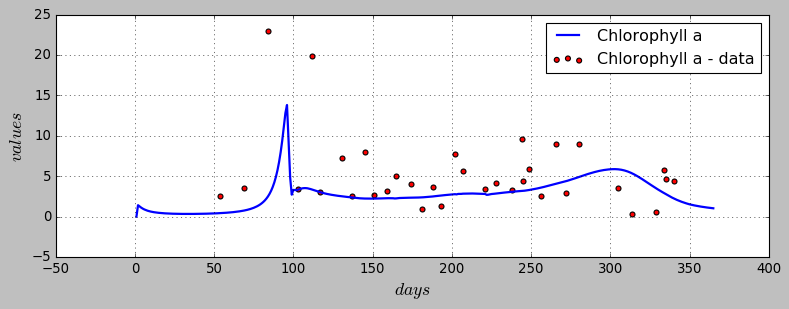

In [8]:
pf.plot_double(chl_a,'Chlorophyll a',chl_rawdata,'Chlorophyll a - data')

#### Run least squares for phytoplankton - resudial function is constructed according to chl_a_data

In [9]:
foo = lff.run_least_squares(lff.construct_least_squares_phy(
    depth, k, latitude, days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het,
    k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox,
    chl_a_data, 3.7))

In [10]:
lff.report_values(foo)

[[Variables]]
    knh4_lim:       0.1 (fixed)
    knox_lim:       0.1 (fixed)
    ksi_lim:        0.1 (fixed)
    kpo4_lim:       0.1 (fixed)
    pbm:            8 (fixed)
    alpha:          0.03 (fixed)
    kexc:           0.015 (fixed)
    kmort:          0.0001 (fixed)
    k_het_phy_gro:  0.20000000 +/- 2.7706e-08 (0.00%) (init = 0.2)
    k_het_phy_lim:  0.60000002 +/- 6.2625e-08 (0.00%) (init = 0.6)
    k_het_pom_gro:  0.2 (fixed)
    k_het_pom_lim:  0.6 (fixed)
    k_het_res:      0.015 (fixed)
    k_het_mort:     0.00999999 +/- 1.5436e-08 (0.00%) (init = 0.01)
    uz:             0.5 (fixed)
    hz:             0.5 (fixed)
    k_nfix:         0.4 (fixed)
    k_nitrif1:      0.1 (fixed)
    k_nitrif2:      0.1 (fixed)
    o2s_nf:         5 (fixed)
    k_anammox:      0.8 (fixed)
    o2s_dn:         10 (fixed)
    k_poml_doml:    0.15 (fixed)
    k_pomr_domr:    1e-05 (fixed)
    k_omox_o2:      1 (fixed)
    tref:           0 (fixed)
    k_doml_ox:      0.1 (fixed)
    k_poml_ox:

In [11]:
knh4_lim = lff.return_par_values(foo, 'knh4_lim')
knox_lim = lff.return_par_values(foo, 'knox_lim')
ksi_lim  = lff.return_par_values(foo, 'ksi_lim')
kpo4_lim = lff.return_par_values(foo, 'kpo4_lim')
pbm      = lff.return_par_values(foo, 'pbm')
alpha    = lff.return_par_values(foo, 'alpha')
kexc     = lff.return_par_values(foo, 'kexc')
kmort    = lff.return_par_values(foo, 'kmort')
k_het_phy_gro = lff.return_par_values(foo, 'k_het_phy_gro')
k_het_phy_lim = lff.return_par_values(foo, 'k_het_phy_lim')
k_het_pom_gro = lff.return_par_values(foo, 'k_het_pom_gro')
k_het_pom_lim = lff.return_par_values(foo, 'k_het_pom_lim')
k_het_res     = lff.return_par_values(foo, 'k_het_res')
k_het_mort    = lff.return_par_values(foo, 'k_het_mort')

In [12]:
chl_a, phy_dgrate, rations = bf.calculate(
    depth, k, latitude, 
    days, temperature, 
    nh4, no2, no3, si, po4, o2,
    phy, par, irradiance, 
    knh4_lim, knox_lim, ksi_lim, kpo4_lim, pbm, alpha, kexc, kmortality,
    het, k_het_phy_gro, k_het_phy_lim, k_het_pom_gro, k_het_pom_lim, k_het_res, k_het_mort, uz, hz,
    k_nfix, k_nitrif1, k_nitrif2, o2s_nf, k_anammox, o2s_dn,
    poml, doml, pomr, domr, 
    k_poml_doml, k_pomr_domr, k_omox_o2, tref, k_doml_ox, k_poml_ox, k_domr_ox, k_pomr_ox)

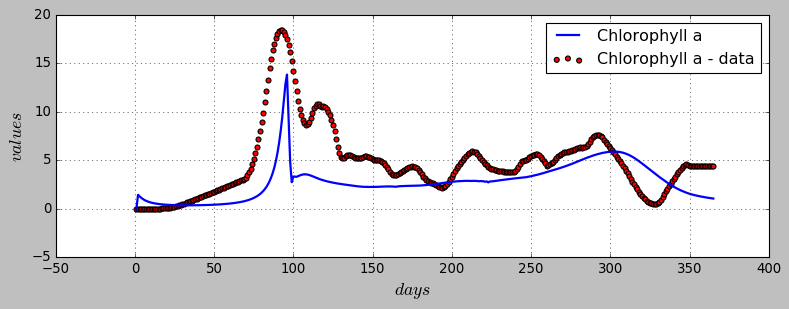

In [13]:
pf.plot_double(chl_a,'Chlorophyll a',chl_a_data,'Chlorophyll a - data')

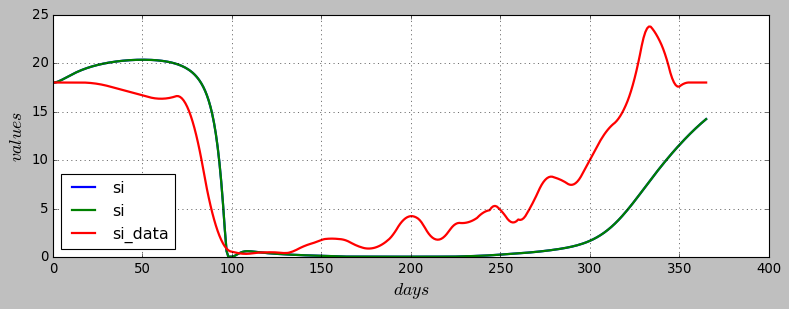

In [14]:
pf.plot_triple(si,'si', si,'si',si_data,'si_data')